# Inference in the full model

This is the same example as considered in [Liu et al.](https://arxiv.org/abs/1801.09037) though we
do not consider the special analysis in that paper. We let the computer
guide us in correcting for selection.

The functions `full_model_inference` and `pivot_plot` below are just simulation utilities
used to simulate results in least squares regression. The underlying functionality
is contained in the function `selectinf.learning.core.infer_full_target`.

In [1]:
import functools

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import regreg.api as rr

from selectinf.tests.instance import gaussian_instance # to generate the data
from selectinf.learning.core import normal_sampler     # our representation of the (limiting) Gaussian data

from selectinf.learning.utils import full_model_inference, pivot_plot
from selectinf.learning.fitters import gbm_fit_sk

We will know generate some data from an OLS regression model and fit the LASSO
with a fixed value of $\lambda$. In the simulation world, we know the
true parameters, hence we can then return
pivots for each variable selected by the LASSO. These pivots should look
(marginally) like a draw from `np.random.sample`. This is the plot below.

In [2]:
np.random.seed(0) # for replicability

def simulate(n=200, 
             p=20, 
             s=5, 
             signal=(0.5, 1), 
             sigma=2, 
             alpha=0.1, 
             B=6000,
             verbose=False):

    # description of statistical problem

    X, y, truth = gaussian_instance(n=n,
                                    p=p, 
                                    s=s,
                                    equicorrelated=False,
                                    rho=0.5, 
                                    sigma=sigma,
                                    signal=signal,
                                    random_signs=True,
                                    scale=False)[:3]


    XTX = X.T.dot(X)
    XTXi = np.linalg.inv(XTX)
    resid = y - X.dot(XTXi.dot(X.T.dot(y)))
    dispersion = np.linalg.norm(resid)**2 / (n-p)

    S = X.T.dot(y)
    covS = dispersion * X.T.dot(X)
    
    # this declares our target as linear in S where S has a given covariance
    sampler = normal_sampler(S, covS) 

    def base_algorithm(XTX, lam, sampler):

        p = XTX.shape[0]
        success = np.zeros(p)

        loss = rr.quadratic_loss((p,), Q=XTX)
        pen = rr.l1norm(p, lagrange=lam)

        scale = 0.
        noisy_S = sampler(scale=scale)
        loss.quadratic = rr.identity_quadratic(0, 0, -noisy_S, 0)
        problem = rr.simple_problem(loss, pen)
        soln = problem.solve(max_its=100, tol=1.e-10)
        success += soln != 0
        
        return set(np.nonzero(success)[0])

    
    lam = 3.5 * np.sqrt(n)
    selection_algorithm = functools.partial(base_algorithm, XTX, lam)
    if verbose:
        print(selection_algorithm(sampler))
    # run selection algorithm

    return full_model_inference(X,
                                y,
                                truth,
                                selection_algorithm,
                                sampler,
                                success_params=(1, 1),
                                B=B,
                                fit_probability=gbm_fit_sk,
                                fit_args={'n_estimators':500})

Let's take a look at what we get as a return value:

In [3]:
while True:
    df = simulate(verbose=True)
    if df is not None:
        break
df.columns

{19}


Index(['B', 'alpha', 'coverage', 'id', 'length', 'lower', 'nfeature',
       'nsample', 'pivot', 'pvalue', 'target', 'upper', 'variable',
       'bonferroni_coverage', 'bonferroni_length', 'bonferroni_lower',
       'bonferroni_pvalue', 'bonferroni_upper', 'naive_coverage',
       'naive_length', 'naive_lower', 'naive_pivot', 'naive_pvalue',
       'naive_upper'],
      dtype='object')

In [4]:
dfs = []
for i in range(30):
    df = simulate()
    if df is not None:
        dfs.append(df)

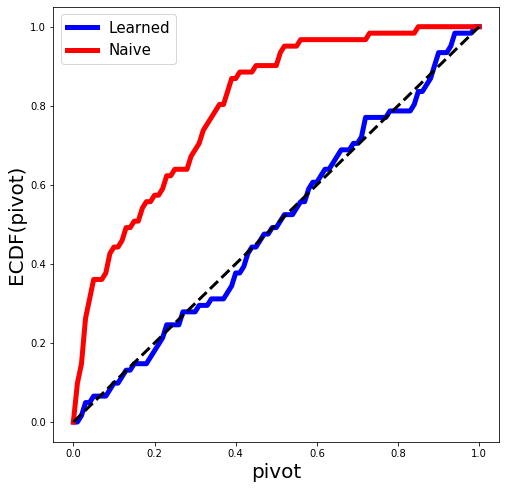

In [5]:
fig = plt.figure(figsize=(8, 8))
results = pd.concat(dfs)
pivot_plot(results, fig=fig);